# Imports

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import copy
import os

# Data loading and preprocessing
Remember to change the path if needed be

### Hyperparameters of preprocessing

In [12]:
m = 2000; M = 12000; 
bin_size = 5;

path = "D:/GitHub/Machine-Learning/Kaggle/"
# path = "C:/Users/Javi/Documents/GitHub/Machine-Learning/Kaggle/"

# # Take the data from Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# path = "/content/drive/My Drive/Colab Notebooks/Kaggle/Kaggle_data/"
# path_results = "/content/drive/My Drive/Colab Notebooks/Kaggle/Kaggle_results/"

In [13]:
savepath = path + 'Kaggle classifiers/bin size 5/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;

In [14]:
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

In [15]:
def spectrum_in_bins(df,m,M,bin_size):
    # Now, let's define the mz ranges, and the label associated to each of them (the mean of the limiting values of each bin)
    range_min = []; range_max = []; range_label = [];
    for mz in range(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_label.append(np.mean([range_min[-1],range_max[-1]]).astype(int))
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        idx_data_in_bins = np.zeros((1,L))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                idx_data_in_bins[0,i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum
                idx_data_in_bins[0,i] = 0   

        # Normalize the amplitude of the spectrum
        idx_data_in_bins[0,:] = idx_data_in_bins[0,:] / np.max(idx_data_in_bins[0,:])
        all_data[idx,:] = idx_data_in_bins
    new_df = pd.DataFrame(data=all_data, columns = range_label, index = df.index)
    return new_df

In [16]:
df_train = df_train.drop_duplicates(subset='ID_sample') # eliminate duplicates
# Let's work without duplicates from now on, to avoid having same sample in training and test_training sets

# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.2, random_state=42) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = spectrum_in_bins(data_train,m,M,bin_size)
spectrum_test_train = spectrum_in_bins(data_test_train,m,M,bin_size)
print('Spectrum regularized!')
# these spectrum_... are our X for training

Training samples: 205 and test_train samples: 52
Spectrum regularized!


In [17]:
def clean_nan_samples(spectrum,targets, c, cat):
# if there are any NaN values, we should remove those samples
    if (targets[cat].isnull().sum() > 0).all(): 
        merged = pd.concat([spectrum , targets],axis=1,copy=True)
        clean = merged.dropna(subset=[cat])
        Y = clean.iloc[:,-9+c].to_numpy().reshape(-1,)
        X = clean.iloc[:,:-9]

    else:
        Y = targets.iloc[:,c].to_numpy().reshape(-1,)
        X = spectrum.copy(deep=True)
    return X , Y

# Try different classifiers
The try_clf function has been built for, given a classifier and a parameter dictionary (for hyperparameter cross-validation), create a classifier for each antibiotic, and return the results. This enables for fast testing of different classifiers. Moreover, the function also takes charge of suppressing NaN values in the targets ocurring for amikacina, levofloxacino and tobramicina.

In [18]:
def try_clf(clf,params,n_cv=5,L1_FEATURE_SELECTION=False, feature_vector_list=None):  # new version! (after Sevilla)
    # new version --> Incorporates feature selection
    t1 = time.time()
    
    best_classifiers = [];
    grid_list = [];
    AUC_train = []; AUC_valid = [];
    
    categories = targets_train.columns[:]    
    for c,cat in enumerate(categories):

        print([cat]) # indicate in which antibiotic we are
        
        # Selection of train and test data (depending on whether there are NaN target values)
        X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
        
        if L1_FEATURE_SELECTION: # a boolean that decides whether to apply L1 feature selection (L1 feature list has to be already defined, and input to the function)
            X_train = apply_l1_feature_selection(X_train,feature_vector_list[c])
            
        # perform a GridSearchCV in order to train a classifier for this antibiotic
        grid = GridSearchCV(clf,param_grid=params,scoring='roc_auc',n_jobs=njobs,pre_dispatch='2*n_jobs', cv=n_cv, iid=False,return_train_score=True)
        grid.fit(X_train, Y_train)

        # print the best parameters (to detect edge values), and save that classifier
        print('The best parameters are: ',grid.best_params_)
        best_clf = grid.best_estimator_
        best_classifiers.append(best_clf)
        grid_list.append(grid)
        
        best_clf = np.where(grid.cv_results_['rank_test_score']==1)[0][0]
        AUC_train.append(grid.cv_results_['mean_train_score'][best_clf])
        AUC_valid.append(grid.cv_results_['mean_test_score'][best_clf])
        
        print('Train AUC: ',np.round(AUC_train[-1],4),' and validation AUC: ',np.round(AUC_valid[-1],4))
        
    avg_AUC_train = np.mean(AUC_train)
    avg_AUC_valid = np.mean(AUC_valid)
    print('\n\nThe average train AUC is',np.round(avg_AUC_train,4),'and the avg validation AUC is',np.round(avg_AUC_valid,4))
    
    t2 = time.time()
    print('\nFull execution took ',np.round(t2-t1,1),'seconds')
    print('\nDONE!')
    return best_classifiers, grid_list, AUC_train, AUC_valid

## Real AdaBoost with HW2 method

In [42]:
from sklearn.metrics import accuracy_score as acc
from sklearn.tree import DecisionTreeClassifier

class OurAdaBoostEnsemble():
    def __init__(self,T):
        self.T = T

    def fit(self,X_train, Y_train):
        T = self.T
        
        Y_train[Y_train==0] = -1 # change labels 0 to -1, if needed

        alpha = np.zeros((T,1))
        Dt_all = np.zeros((T,X_train.shape[0]))
        Dt_all[0,:] = np.ones((1,X_train.shape[0])) / X_train.shape[0]  # Initialize all weights as 1 / n_samples

        outputs_train = np.zeros((T,Y_train.shape[0]))

        tree_list = []

        for i in range(T):
            mytree = DecisionTreeClassifier(max_depth=2)
            mytree.fit(X_train,Y_train,sample_weight=Dt_all[i,:])
            tree_list.append(mytree)

            # For real-valued predictions:
            outputs_train[i,:] = np.dot(mytree.predict_proba(X_train),mytree.classes_)
            
            # Get gamma and alpha_i values
            gamma = np.dot(Dt_all[i,:],np.multiply(outputs_train[i,:],Y_train))
            alpha[i] = 0.5 * np.log((1+gamma)/(1-gamma))

            # Update emphasis function (except if in the last iteration)
            if (i < T-1):
                emphasis = np.multiply(Dt_all[i,:],np.exp(-1*alpha[i]*np.multiply(outputs_train[i,:],Y_train)))
                Dt_all[i+1,:] = emphasis / np.sum(emphasis) # normalize

        # save neccessary parameters for the other methods
        self.T = T
        self.alpha = alpha
        self.tree_list = tree_list

        return self

    def predict_proba(self, X):
#         outputs = np.zeros((self.T,X.shape[0]))
#         for t in range(self.T):
#             mytree = self.tree_list[t]
#             outputs[t,:] = mytree.predict_proba(X)[:,-1].T
#         f = np.sum(np.multiply(outputs,self.alpha),axis=0).reshape((-1,1))


        outputs = np.zeros((self.T,X.shape[0]))
        for t in range(self.T):
            mytree = self.tree_list[t]
            outputs[t,:] = mytree.predict_proba(X)[:,1].T
        f = np.sum(np.multiply(outputs,self.alpha),axis=0).reshape((-1,1)) / np.sum(self.alpha)
        return f


Results are not very good, but actually somehow better than those of other methods (LogReg, RF...). Remarkably, they are substantially better than those of AdaBoostClassifier of sklearn (with 200 estimators, also depth 2, it yields 0.5644).

## Implementing AdaBoost for all categories, and getting Y_test predictions

In [ ]:
spectrum_full_train = spectrum_in_bins(data,m,M,bin_size)
targets_full_train = targets.copy(deep=True)

In [44]:
ab_ours = OurAdaBoostEnsemble(T=500)
ab_ours.fit(X_train,Y_train)
a = ab_ours.predict_proba(X)
print(a.shape)

(214, 1)


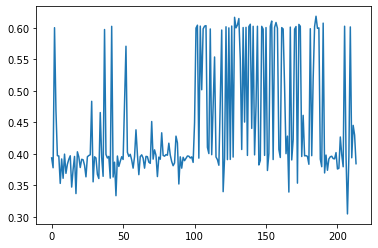

In [45]:
plt.plot(a)

In [37]:
b = np.sum(list_of_best_clfs_list[0][0].alpha)
print(b)

c = a / b
print(c.shape)
print(c)

110.645105392296
(214, 1)
[[0.39362984]
 [0.37798153]
 [0.60046148]
 [0.46865703]
 [0.39715514]
 [0.39667166]
 [0.35314687]
 [0.39196603]
 [0.36126931]
 [0.39962064]
 [0.36908676]
 [0.38354846]
 [0.39142687]
 [0.39696948]
 [0.34730252]
 [0.37519915]
 [0.39594707]
 [0.33696071]
 [0.40334569]
 [0.39516639]
 [0.37832477]
 [0.39141203]
 [0.3906933 ]
 [0.38191985]
 [0.36354434]
 [0.39545626]
 [0.39739017]
 [0.39857901]
 [0.4835309 ]
 [0.35559784]
 [0.39537912]
 [0.39352547]
 [0.36746528]
 [0.36087883]
 [0.46566959]
 [0.39440932]
 [0.36437665]
 [0.59756876]
 [0.39917476]
 [0.39347177]
 [0.39596213]
 [0.36143302]
 [0.60262785]
 [0.36325518]
 [0.38682924]
 [0.33359138]
 [0.39660577]
 [0.38008052]
 [0.38811795]
 [0.39546335]
 [0.3911763 ]
 [0.47808918]
 [0.57099182]
 [0.40261212]
 [0.39598302]
 [0.39931097]
 [0.39030715]
 [0.37737661]
 [0.39568528]
 [0.43823565]
 [0.39948479]
 [0.36699659]
 [0.39574226]
 [0.39849431]
 [0.39329836]
 [0.37734058]
 [0.39603867]
 [0.39559115]
 [0.38678298]
 [0.3850

In [40]:
from sklearn.metrics import roc_curve
fpr,tpr,_ = roc_auc_score(Y,a)
print(z1)
z2 = roc_auc_score(Y,c)
print(z2)

0.9753536693191865
0.9753536693191865


# Generate final results in CSV format
From "Jagger_4_GenerateCSV_v2"

In [59]:
def get_unique_spectre(spectre, df):
  # Include the ID_sample column for the group_by
  spectre['ID_sample'] = df.ID_sample
  # MEAN OF THE SPECTRE
  spectre = spectre.groupby('ID_sample').mean().reset_index()
  return spectre

# to be applyied to each category
def apply_l1_feature_selection(spectrum_train,vect): # vect is l1_feat_list[c]
    new_spectrum = spectrum_train.copy(deep=True).iloc[:,vect]   
    return new_spectrum

def generate_csv_from_clf(clf_list, path, path_results, file_name, L1_FEATURE_SELECTION=False, feature_vector_list = None):
  # classifiers must be provided with parameters, and in a list [clf_antibiotic0, clf_antibiotic1, ...]
  # spectrum and targets full train (containing all training points) will be used for training the clfs in clf list
  # df_test must be provided as loaded from the file

  # read all data from files
  zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
  df_full_train = _pickle.loads(zf.open('TrainData.pkl').read());   zf.close()

  zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
  df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read());   zf.close()

  # Process test df to get UNIQUE samples and convert to spectrum

  # df_unique_test = df_test.drop_duplicates(subset='ID_sample')

  spectrum_test_forcsv = spectrum_in_bins(df_test,m,M,bin_size)
  spectrum_test_forcsv = get_unique_spectre(spectrum_test_forcsv, df_test)
    
  # Process train set to later train the clfs
  spectrum_full_train = spectrum_in_bins(df_full_train.iloc[:,-2:],m,M,bin_size)
  targets_full_train  = df_full_train.iloc[:,1:-2]  

  # read the submission example file
  df_submission = pd.read_csv(path+'SubmissionSample.csv') 
  categories = df_submission.columns[1:]
  df_submission['ID']= spectrum_test_forcsv['ID_sample'].values
  # To eliminate the ID_sample from the spectrum
  spectrum_test_forcsv = spectrum_test_forcsv.drop(columns=['ID_sample'])
  for c, cat in enumerate(categories): 
      # clean NaN values
      X_train, Y_train = clean_nan_samples(spectrum_full_train,targets_full_train, c, cat)

      if L1_FEATURE_SELECTION: # a boolean that decides whether to apply L1 feature selection (L1 feature list has to be already defined, and input to the function)
        X_train= apply_l1_feature_selection(X_train,feature_vector_list[c])
        X_test = apply_l1_feature_selection(spectrum_test_forcsv,feature_vector_list[c])

      # fit the classifier
      clf_base = clf_list[c].fit(X_train,Y_train)
      # Compute its test prestiction and save this output
    
    
#       o_test = clf_base.predict_proba(spectrum_test_forcsv)[:,1]
      o_test = clf_base.predict_proba(X_test)
        
      df_submission[cat] = o_test

  # Save the dataframe with the predicted outputs
  df_submission = df_submission.set_index('ID')
  df_submission.to_csv(path_results + file_name + '.csv')
  print('DONE!')
  return df_submission

In [51]:
clf_list = [OurAdaBoostEnsemble(T=500)]*9
name = 'OurAdaBoost_bs5'
df_submission = generate_csv_from_clf(clf_list,path,path_results, name)
print('File: '+name+' has been successfully generated')

DONE!
File: OurAdaBoost_bs5 has been successfully generated


In [52]:
with open(savepath+'l1_best_clfs_nodup.data', 'rb') as filehandle:
    l1_best_clfs = pickle.load(filehandle)
with open(savepath+'l1_feat_list_nodup.data', 'rb') as filehandle:
    l1_feat_list = pickle.load(filehandle)

In [60]:
clf_list = [OurAdaBoostEnsemble(T=500)]*9
name = 'OurAdaBoost_bs5_withL1FeatSelect'
df_submission = generate_csv_from_clf(clf_list,path,path_results, name, True, l1_feat_list)
print('File: '+name+' has been successfully generated')

DONE!
File: OurAdaBoost_bs5_withL1FeatSelect has been successfully generated
